In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir('../notebook_format')
from formats import load_style
load_style()

In [2]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6 # change default figure size

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload 
%autoreload 2

from sklearn import metrics
from sklearn.linear_model import LogisticRegression

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,scikit-learn

Ethen 2016-08-11 15:29:33 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
scikit-learn 0.17.1


# Logistic Regression

**Logistic regression** is an excellent tool to know for classification problems, which are problems where the output value that we wish to predict only takes on only a small number of discrete values. Here we'll focus on the binary classification problem, where the output can take on only two distinct classes. To make our examples more concrete, we will consider the Glass dataset.

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data'
col_names = [ 'id','ri','na','mg','al','si','k','ca','ba','fe','glass_type' ]
glass = pd.read_csv( url, names = col_names, index_col = 'id' )
glass.sort_values( 'al', inplace = True )

# convert the glass type into binary outcome
# types 1, 2, 3 are window glass
# types 5, 6, 7 are household glass
glass['household'] = glass['glass_type'].map({ 1: 0, 2: 0, 3: 0, 5: 1, 6: 1, 7: 1 })
glass.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type,household
id,,,,,,,,,,,
22,1.51966,14.77,3.75,0.29,72.02,0.03,9.00,0.0,0.00,1,0
185,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.0,0.00,6,1
40,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1,0
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1,0
51,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.0,0.16,1,0


Our task is to predict the `household` column using the `al` column. Let's visualize the relationship between the input and output and also train the logsitic regression to see the outcome that it produces.

In [4]:
logreg = LogisticRegression( C = 1e9 )
X = glass['al'].reshape( -1, 1 ) # sklearn doesn't accept 1d-array, convert it to 2d
y = np.array(glass['household'])
logreg.fit( X, y )

# predict the probability that each observation belongs to class 1
# The first column indicates the predicted probability of class 0, 
# and the second column indicates the predicted probability of class 1
glass['household_pred_prob'] = logreg.predict_proba(X)[ :, 1 ]

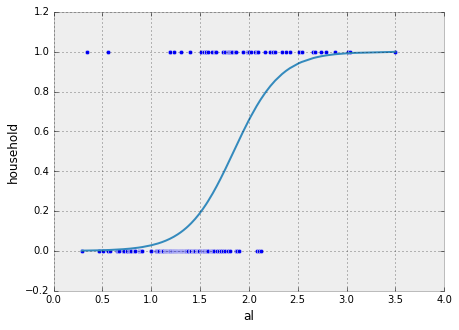

In [5]:
# plot the predicted probability (familiarize yourself with the S-shape)
plt.figure( figsize = ( 7, 5 ) )
plt.scatter( glass['al'], glass['household'] )
plt.plot( glass['al'], glass['household_pred_prob'] )
plt.xlabel('al')
plt.ylabel('household')
plt.show()

As we can see logistic regression can output the probabilities of obsevation belonging to a specific class and these probabilities can be converted into class predictions by choosing a cutoff value (e.g. probability higher than 0.5 is classified as class 1).


## Logsitic Function

In **Logistic Regression**, the log-odds of a categorical response being "true" (1) is modeled as a linear combination of the features:

\begin{align*}
    \log \left({p\over 1-p}\right) &= w_0 + w_1x_1, ..., w_jx_j \nonumber \\
    &= w^Tx \nonumber
\end{align*}

Where:

- $w_{0}$ is the intercept term, and $w_1$ to $w_j$ represents the parameters for all the other features (a total of j features).
- By convention of we can assume that $x_0 = 1$, so that we can re-write the whole thing using the matrix notation $w^Tx$.

This is called the **logit function**. The equation can be re-arranged into the **logistic function**:

$$p = \frac{e^{w^Tx}} {1 + e^{w^Tx}}$$

Or in the more commonly seen form:

$$h_w(x) = \frac{1}{ 1 + e^{-w^Tx} }$$ 

Let's take a look at the plot of the function:

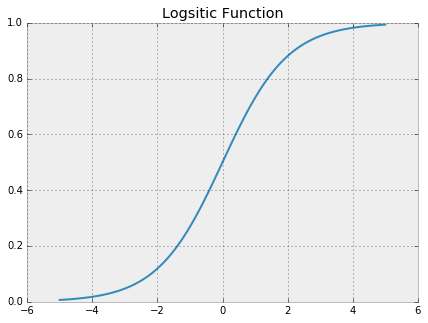

In [6]:
plt.figure( figsize = ( 7, 5 ) )
x_values = np.linspace( -5, 5, 100 )
y_values = [ 1 / (1 + np.exp(-x) ) for x in x_values ]
plt.plot( x_values, y_values )
plt.title('Logsitic Function')
plt.show()

The **logistic function** has some nice properties. The y-value represents the probability and it is always bounded between 0 and 1, which is want we wanted for probabilities. For an x value of 0 you get a 0.5 probability. Also as you get more positive x value you get a higher probability, on the other hand, a more negative x value results in a lower probability.

Toy sample code of how to predict the probability given the data and the weight is provided below.

In [7]:
def predict_probability( data, weights ):
    """probability predicted by the logistic regression"""
    score = np.dot( data, weights )
    predictions = 1 / ( 1 + np.exp(-score) )    
    return predictions

## Interpreting the Intercept

We can check at the coefficient of the logistic regression does in fact generate the log-odds.

In [8]:
# compute predicted log-odds for al = 2 using the equation
# convert log-odds to odds
# convert odds to probability
logodds = logreg.intercept_ + logreg.coef_[0] * 2
odds = np.exp(logodds)
prob = odds / ( 1 + odds )
print(prob)

logreg.predict_proba(2)[ :, 1 ]

[ 0.65638445]


array([ 0.65638445])

In [9]:
# examine the coefficient for al
print( 'a1', logreg.coef_[0] )

a1 [ 4.18040386]


**Interpretation:** 1 unit increase in `al` is associated with a 4.18 unit increase in the log-odds of the observation being classified as `household 1`. We can confirm that again by doing the calculation ourselves.

In [10]:
# increasing al by 1 (so that al=3) increases the log-odds by 4.18
logodds = 0.64722323 + 4.1804038614510901
odds = np.exp(logodds)
prob = odds / ( 1 + odds )
print(prob)

logreg.predict_proba(3)[ :, 1 ]

0.992058083917


array([ 0.99205808])

## Defining The Cost Function

When utilizing logistic regression, we are trying to learn the $w$ values in order to maximize the probability of correctly classifying our glasses. Let's say someone did give us some $w$ values of the logisic regression model, how would we determine if they were good values or not? What we would hope is that for the household of class 1, the probability values are close to 1 and for the household of class 0 the probability is close to 0.

But we don't care about getting the correct probability for just one observation, we want to correctly classify all our observations. If we assume our data are independent and identically distributed (think of it as all of them are treated equally), we can just take the product of all our individually calculated probabilities and that is the **cost function we want to maximize**. So in math:  

$$\prod_{class1}h_w(x)\prod_{class0}1 - h_w(x)$$ 

The $\prod$ symbol means take the product of the $h_w(x)$ for the observations that are classified as that class. You will notice that for observations that are labeled as class 0, we are taking 1 minus the logistic function. That is because we are trying to find a value to maximize, and since observations that are labeled as class 0 should have a probability close to zero, 1 minus the probability should be close to 1. Next we will re-write the original cost function as:

$$\ell(w) = \sum_{i=1}^{N}y_{i}log(h_w(x_{i})) + (1-y_{i})log(1-h_w(x_{i}))$$

Where:

- We define $y_{i}$ to be 1 when the $i_{th}$ observation is labeled class 1 and 0 when labeled as class 0, then we only compute $h_w(x_{i})$ for observations that are labeled class 1 and $1 - h_w(x_{i})$ for observations that are labeled class 0, which is still the same idea as the original function.
- Next we'll transform the original $h_w(x_{i})$ by taking the log. As we'll later see this logarithm transformation will make our cost function more convenient to work with, and because the logarithm is a monotonically increasing function, the logarithm of a function achieves its maximum value at the same points as the function itself. When we take the log, our product across all data points, it becomes a sum. See [log rules](http://www.mathwords.com/l/logarithm_rules.htm) for more details (Hint: log(ab) = log(a) + log(b)).
- The $N$ simply represents the total number of the data.

Often times you'll also see the notation above be simplified in the form of a maximum likelihood estimator:

$$ \ell(w) = \sum_{i=1}^{N} log \big( P( y_i \mid x_i, w ) \big) $$

The equation above simply denotes the idea that , $\mathbf{w}$ represents the parameters we would like to estimate the parameters $w$ by maximizing conditional probability of $y_i$ given $x_i$.

Now by definition of probability in the logistic regression model: $h_w(x_{i}) = 1 \big/ 1 + e^{-w^T x_i}$ and $1- h_w(x_{i}) = e^{ -w^T x_i } \big/ ( 1 + e^{ -w^T x_i } )$. By substituting these expressions into our $\ell(w)$ equation and simplifying it further we can obtain  a simpler expression.

\begin{align*}
    \ell(w) &= \sum_{i=1}^{N}y_{i}log(h_w(x_{i})) + (1-y_{i})log(1-h_w(x_{i})) \nonumber \\
    &= \sum_{i=1}^{N} y_{i} log( \frac{1}{ 1 + e^{ -w^T x_i } } ) + ( 1 - y_{i} )
    log( \frac{ e^{ -w^T x_i } }{ 1 + e^{ -w^T x_i } } ) \nonumber \\
    &= \sum_{i=1}^{N} -y_{i} log( 1 + e^{ -w^T x_i } ) + ( 1 - y_{i} )
    ( -w^T x_i - log( 1 + e^{ -w^T x_i } ) ) \nonumber \\
    &= \sum_{i=1}^{N} ( y_{i} - 1 ) ( w^T x_i ) - log( 1 + e^{ -w^T x_i } ) \nonumber
\end{align*}

We'll use the formula above to compute the log likelihood for the entire dataset, which is used to assess the convergence of the algorithm. Toy code provided below.

In [11]:
def compute_avg_log_likelihood( data, label, weights ):
    """
    the function uses a simple check to prevent overflow problem, 
    where numbers gets too large to represent and is converted to inf
    an example of overflow is provided below, when this problem occurs,
    simply use the original score (without taking the exponential)
    
    scores = np.array( [ -10000, 200, 300 ] )
    logexp = np.log( 1 + np.exp(-scores) )
    logexp  
    """
    scores = np.dot( data, weights )
    logexp = np.log( 1 + np.exp(-scores) )
    
    # simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    log_likelihood = np.sum( ( label - 1 ) * scores - logexp ) / data.shape[0]    
    return log_likelihood

**Note:** We made one tiny modification to the log likelihood function We added a ${1/N}$ term which averages the log likelihood accross all data points. The ${1/N}$ term will make it easier for us to compare stochastic gradient ascent with batch gradient ascent later.

## Gradient

Now that we obtain the formula to assess our algorithm, we'll dive into the meat of the algorithm, which is to derive the gradient for the formula (the derivative of the formula with respect to each coefficient):

$$\ell(w) = \sum_{i=1}^{N} ( y_{i} - 1 ) ( w^T x_i ) - log( 1 + e^{ -w^T x_i } )$$

And it turns out the derivative of log likelihood with respect to to a single coefficient $w_j$ is as follows (the form is the same for all coefficients):

$$
\frac{\partial\ell(w)}{\partial w_j} = \sum_{i=1}^N (x_{ij})\left( y_i - \frac{1}{ 1 + e^{-w^Tx_i} } \right )
$$

To compute it, you simply need the following two terms:

- $\left( y_i - \frac{1}{ 1 + e^{-w^Tx_i} } \right )$ is the vector containing the difference between the predicted probability and the original label.
- $x_{ij}$ is the vector containing the $j_{th}$ feature's value.
 
For detail of the derivation, consider going through the [Coursersa's Course: Washington Classification](https://www.coursera.org/learn/ml-classification), or search it up on the web. Put it in code, the formula above is simply:

In [12]:
def feature_derivative( errors, feature ):
    derivative = np.dot( errors, feature )
    return derivative

## Stochastic/Mini-batch Gradient

The problem with computing the gradient (or so called batched gradient) is the term $\sum_{i=1}^{N}$. This means that we must sum the contributions over all the data points to calculate the gradient, and this can be problematic if the dataset we're studying is extremely large. Thus, in stochastic gradient, we can use a single point as an approximation to the gradient:

$$
\frac{\partial\ell_i(w)}{\partial w_j} = (x_{ij})\left( y_i - \frac{1}{ 1 + e^{-w^Tx_i} } \right )
$$

**Note1:** Because the **Stochastic Gradient** algorithm uses each row of data in turn to update the gradient, if our data has some sort of implicit ordering, this will negatively affect the convergence of the algorithm. At an extreme, what if we had the data sorted so that all positive reviews came before negative reviews?  In that case, even if most reviews are negative, we might converge on an answer of +1 because we never get to see the other data. To avoid this, one practical trick is to shuffle the data before we begin so the rows are in random order.

**Note2:** Stochastic gradient compute the gradient using only 1 data point to update the the parameters, while batch gradient uses all $N$ data points. An alternative to these two extremes is a simple change that allows us to use a **mini-batch** of $B \leq N$ data points to calculate the gradient. This simple approach is faster than batch gradient but less noisy than stochastic gradient that uses only 1 data point. Given a mini-batch (or a set of data points) $\mathbf{x}_{i}, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$, the gradient function for this mini-batch of data points is given by:

$$
\sum_{s = i}^{i+B} \frac{\partial\ell_s(w)}{\partial w_j} = \frac{1}{B} \sum_{s = i}^{i+B} (x_{sj})\left( y_i - \frac{1}{ 1 + e^{-w^Tx_i} } \right )
$$

Here, the $\frac{1}{B}$ means that we are normalizing the gradient update rule by the batch size $B$. In other words, we update the coefficients using the **average gradient over data points** (instead of using a pure summation). By using the average gradient, we ensure that the magnitude of the gradient is approximately the same for all batch sizes. This way, we can more easily compare various batch sizes and study the effect it has on the algorithm.

## Implementation

Recall our task is to find the optimal value for each individual weight to lower the cost. This requires taking the partial derivative of the cost/error function with respect to a single weight, and then running gradient descent for each individual weight to update them. Thus, for any individual weight $w_j$, we'll compute the following:

$$ w_j^{(t + 1)} = w_j^{(t)} + \alpha * \sum_{s = i}^{i+B} \frac{\partial\ell_s(w)}{\partial w_j}$$ 

Where:

- $\alpha$ denotes the the learning rate or so called step size, in other places you'll see it denoted as $\eta$.
- $w_j^{(t)}$ denotes the weight of the $j_{th}$ feature at iteration $t$.

And we'll do this iteratively for each weight, many times, until the whole network's cost function is minimized.

In [13]:
# put the code together into one cell

def predict_probability( data, weights ):
    """probability predicted by the logistic regression"""
    score = np.dot( data, weights )
    predictions = 1 / ( 1 + np.exp(-score) )    
    return predictions

def compute_avg_log_likelihood( data, label, weights ):
    """
    the function uses a simple check to prevent overflow problem, 
    where numbers gets too large to represent and is converted to inf
    an example of overflow is provided below, when this problem occurs,
    simply use the original score (without taking the exponential)
    
    scores = np.array( [ -10000, 200, 300 ] )
    logexp = np.log( 1 + np.exp(-scores) )
    logexp  
    """
    scores = np.dot( data, weights )
    logexp = np.log( 1 + np.exp(-scores) )
    
    # simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    log_likelihood = np.sum( ( label - 1 ) * scores - logexp ) / data.shape[0]    
    return log_likelihood

In [14]:
def logistic_regression( data, label, step_size, batch_size, max_iter ):
     
    # weights of the model are initialized as zero
    data_num = data.shape[0]
    feature_num = data.shape[1]   
    weights = np.zeros(data.shape[1])
    
    # `i` keeps track of the starting index of current batch
    # and shuffle the data before starting
    i = 0 
    permutation = np.random.permutation(data_num)
    data, label = data[permutation], label[permutation]
      
    # do a linear scan over data, for each iteration update the weight using 
    # batches of data, and store the log likelihood record to visualize convergence
    log_likelihood_record = []
    for _ in range(max_iter):
        
        # extract the batched data and label use it to compute
        # the predicted probability using the current weight and the errors
        batch = slice( i, i + batch_size )
        batch_data, batch_label = data[batch], label[batch]
        predictions = predict_probability( batch_data, weights )
        errors = batch_label - predictions
        
        # loop over each coefficient to compute the derivative and update the weight
        for j in range(feature_num): 
            derivative = np.dot( errors, batch_data[ :, j ] )      
            weights[j] += step_size * derivative / batch_size
        
        # track whether log likelihood is increasing after
        # each weight update
        log_likelihood = compute_avg_log_likelihood(
            data = batch_data, 
            label = batch_label,
            weights = weights
        )
        log_likelihood_record.append(log_likelihood)
               
        # update starting index of for the batches
        # and if we made a complete pass over data, shuffle again 
        # and refresh the index that keeps track of the batch
        i += batch_size
        if i + batch_size > data_num:
            permutation = np.random.permutation(data_num)
            data, label = data[permutation], label[permutation]
            i = 0
                
    # We return the list of log likelihoods for plotting purposes.
    return weights, log_likelihood_record

## Comparing Result and Convergence Behavior

We'll use the logistic regression code that we've implemented and compare the predicted auc score with the scikit-learn's implementation. This only serves to check that the predicted results are similar and that our toy code is correctly implemented. Then we'll also explore the convergence difference between batch gradient descent and stochastic gradient descent.

In [15]:
# manually append the coefficient term
data = np.c_[ np.ones(X.shape[0]), X ]

# using our logistic regression code
weights_batch, log_likelihood_batch = logistic_regression(
    data = data,
    label = np.array(y),
    step_size = 5e-1, 
    batch_size = X.shape[0], # batch gradient descent
    max_iter = 200
)

In [16]:
# compare both logistic regression's auc score
logreg = LogisticRegression( C = 1e9 )
logreg.fit( X, y )
pred_prob = logreg.predict_proba(X)[ :, 1 ]

proba = predict_probability( data, weights_batch )

# check that the auc score is similar
auc1 = metrics.roc_auc_score( y, pred_prob )
auc2 = metrics.roc_auc_score( y, proba )
print( 'auc', auc1, auc2 )

auc 0.869902562252 0.869902562252


In [17]:
# the weight may be different, because there's a regularization term C
# when using the Logistic Regression code from scikit learn
print( logreg.intercept_, logreg.coef_[0] )
print(weights_batch)

[-7.71358449] [ 4.18040386]
[-3.96151729  1.90643504]


In [18]:
weights_sgd, log_likelihood_sgd = logistic_regression(
    data = data,
    label = y,
    step_size = 5e-1, 
    batch_size = 30, # stochastic gradient descent
    max_iter = 200
)

In [19]:
weights_minibatch, log_likelihood_minibatch = logistic_regression(
    data = data,
    label = y,
    step_size = 5e-1, 
    batch_size = 100, # mini-batch gradient descent
    max_iter = 200
)

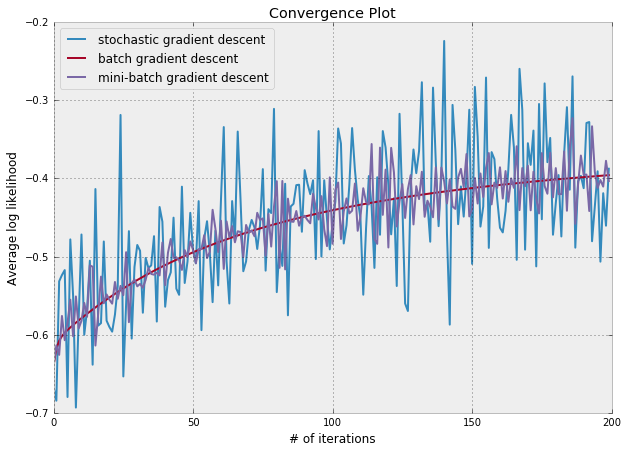

In [20]:
# we can see that the it's a good idea to use mini-batch gradient descent
# since it strikes a good balance between batch gradient, which convergences 
# steadily but can be computationly too expensive when the dataset is too large,
# and stochastic gradient, which is faster to train, but the result can be too noisy
plt.figure( figsize = ( 10, 7 ) )
plt.plot( log_likelihood_sgd, label = 'stochastic gradient descent' )
plt.plot( log_likelihood_batch, label = 'batch gradient descent' )
plt.plot( log_likelihood_minibatch, label = 'mini-batch gradient descent' )
plt.legend( loc = 'best' )
plt.xlabel('# of iterations')
plt.ylabel('Average log likelihood')
plt.title('Convergence Plot')
plt.show()

## Pros and Cons of Logistic Regression

**Pros:**

- Highly interpretable (if you remember how).
- Model training and prediction are fast.
- Almost no parameter tuning is required (excluding regularization).
- Outputs well-calibrated predicted probabilities.

**Cons:**

- Presumes a linear relationship between the features
- Performance is (generally) not competitive with the best supervised learning methods.
- Can't automatically learn feature interactions.

## Reference

- [Coursersa's Course: Washington Classification](https://www.coursera.org/learn/ml-classification)
- [General Assembly's Data Science Course's Notebook on Logistic Regression](http://nbviewer.jupyter.org/github/justmarkham/DAT8/blob/master/notebooks/12_logistic_regression.ipynb)